# Section 5.4 — Bayesian difference between means

This notebook contains the code examples from [Section 5.4 Bayesian difference between means]() from the **No Bullshit Guide to Statistics**.

See also:
- [Half_a_dozen_dmeans_in_Bambi.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/Half_a_dozen_dmeans_in_Bambi.ipynb)
- [t-test.ipynb](./explorations/bambi/t-test.ipynb)
- Examples: https://github.com/treszkai/best/tree/master/examples
- Links: https://www.one-tab.com/page/HoSHco_iSG-MHXG7kXOj7g



#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import bambi as bmb
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/bayes/dmeans"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

## Model

## Example 1: electricity prices

Electricity prices from East End and West End

### Electricity prices dataset

In [4]:
eprices = pd.read_csv("../datasets/eprices.csv")
eprices.groupby("loc")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
loc,,,,,,,,
East,9.0,6.155556,0.877655,4.8,5.5,6.3,6.5,7.7
West,9.0,9.155556,1.562139,6.8,8.3,8.6,10.0,11.8


### Bayesian model
TODO: add formulas

### Bambi model

In [5]:
from ministats.bayes import bayes_dmeans

epricesW = eprices[eprices["loc"]=="West"]["price"]
epricesE = eprices[eprices["loc"]=="East"]["price"]
mod1, idata1 = bayes_dmeans(epricesW, epricesE, group_name="loc", var_name="price", groups=["West", "East"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, loc, sigma_loc]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


### Model fitting and analysis

In [6]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata1, group_name="loc");
az.summary(idata1, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_West", "sigma_East", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,2.960,0.686,1.600,4.267
sigma_West,1.582,0.456,0.821,2.473
sigma_East,0.917,0.275,0.464,1.441
dstd,0.666,0.526,-0.303,1.769
nu,21.105,14.173,1.908,49.581
cohend,2.369,0.722,1.078,3.868


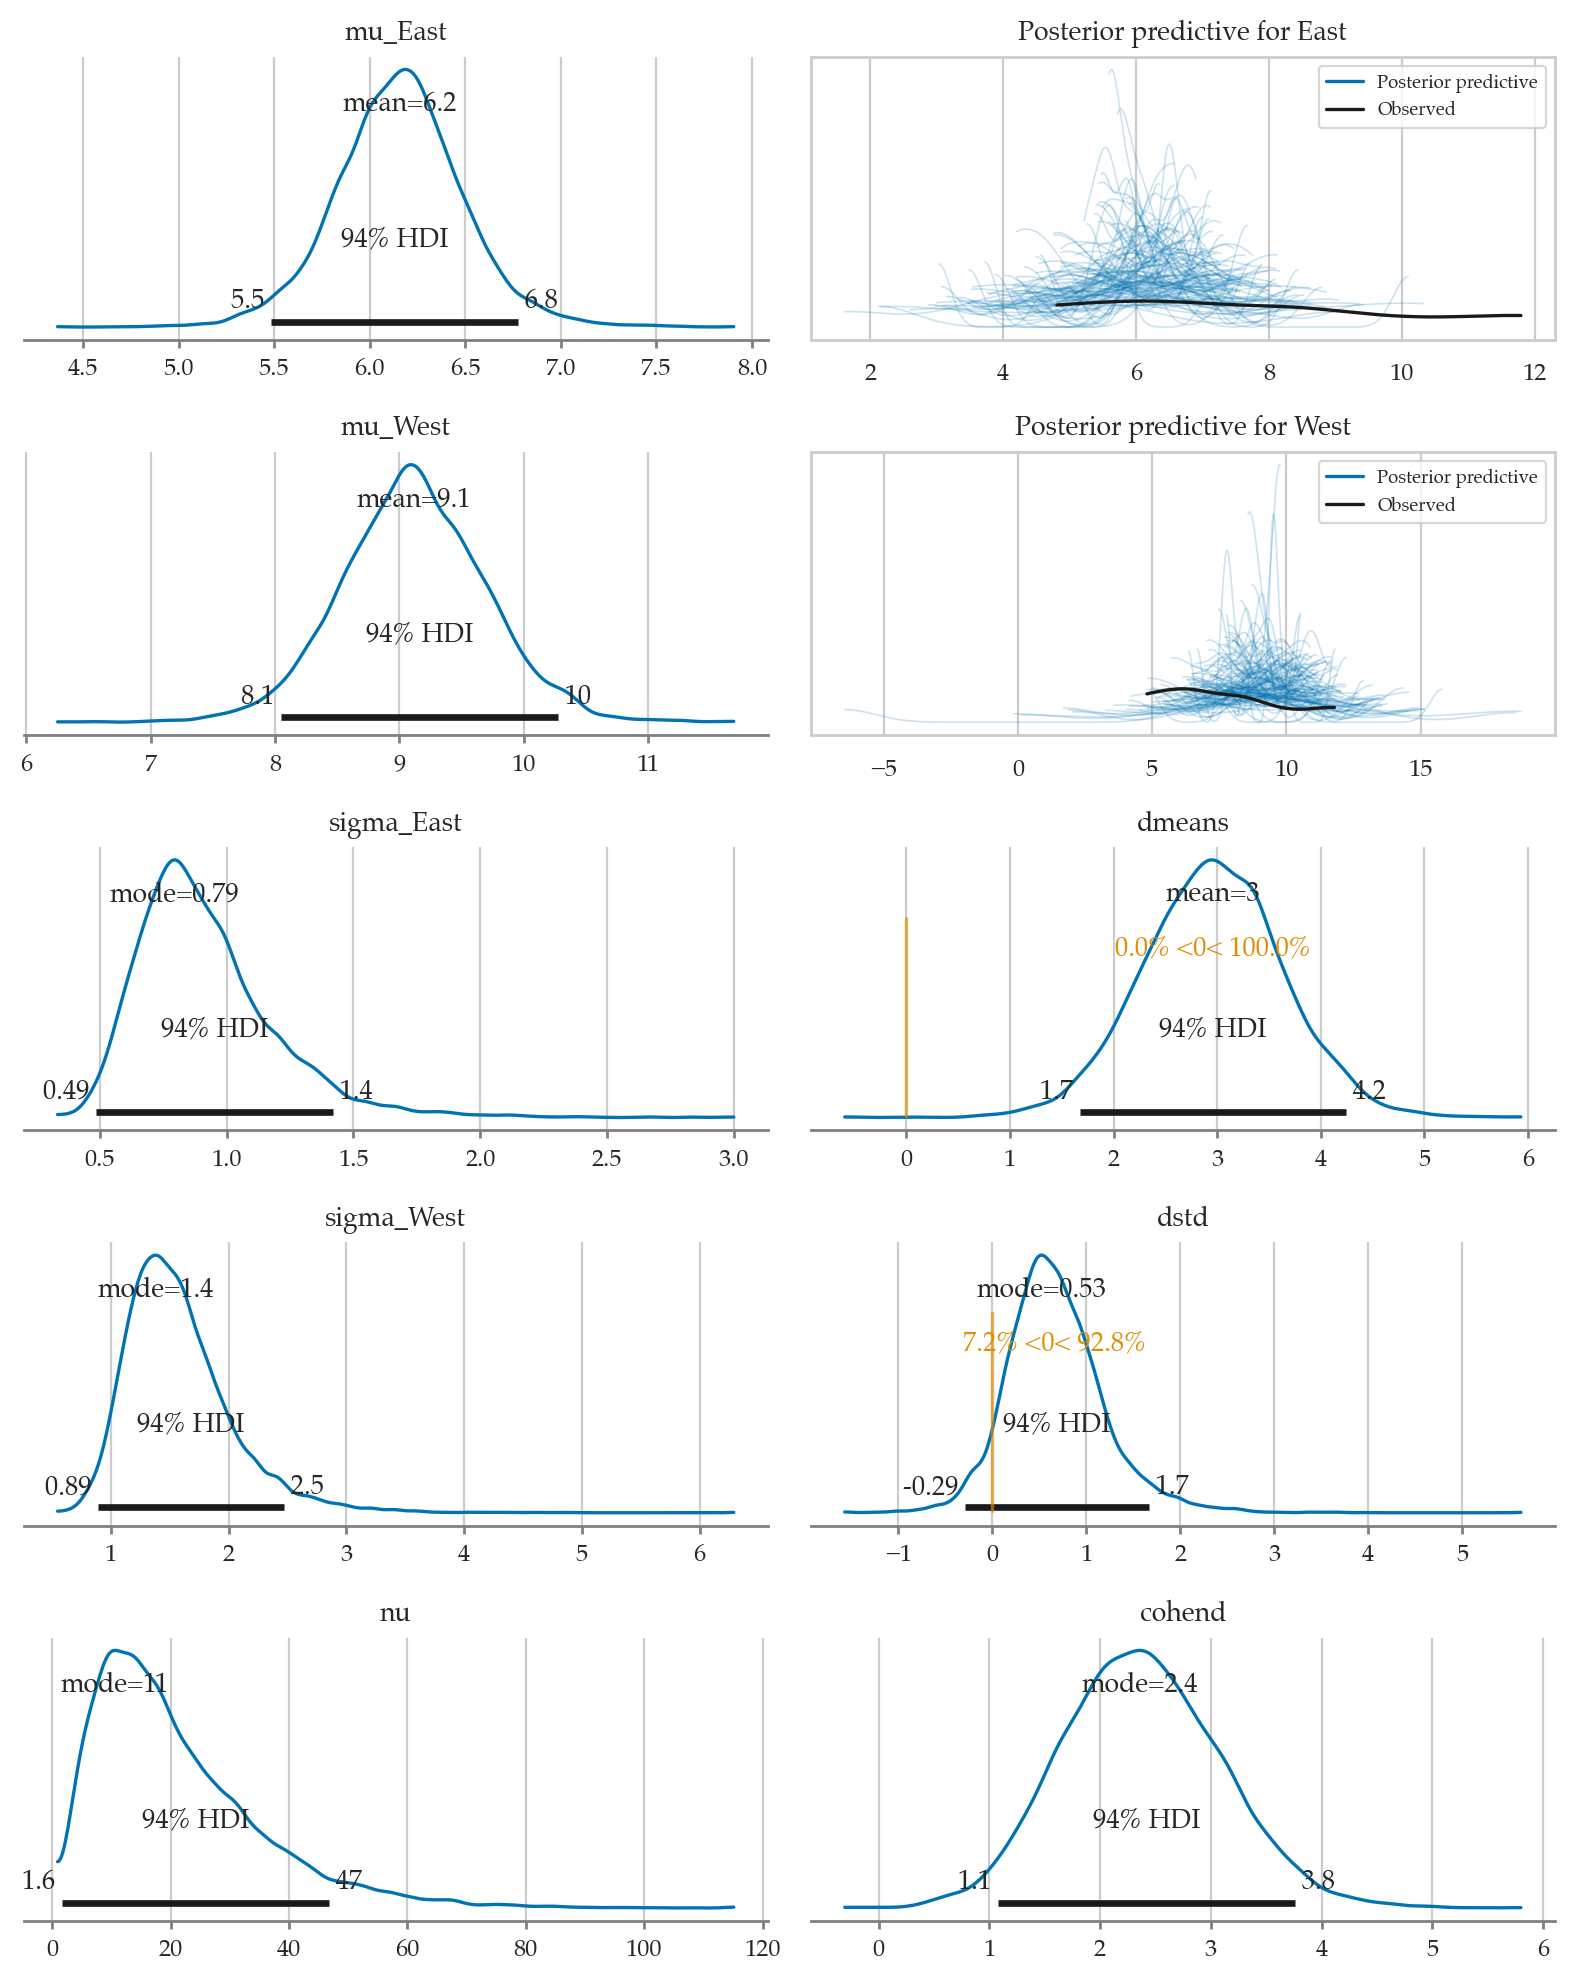

In [7]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod1, idata1, group_name="loc");

### Compare to previous results

### Conclusions

## Example 2: comparing IQ scores

We'll look at IQ scores data taken from a the paper *Bayesian Estimation Supersedes the t-Test* (BEST) by John K. Kruschke.

### Data

In [8]:
iqs2 = pd.read_csv("../datasets/iqs2.csv")
iqs2.groupby("group")["iq"].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
ctrl,42.0,100.357143,2.516496,88.0,100.0,100.5,101.0,105.0
treat,47.0,101.914894,6.021085,82.0,100.0,102.0,103.0,124.0


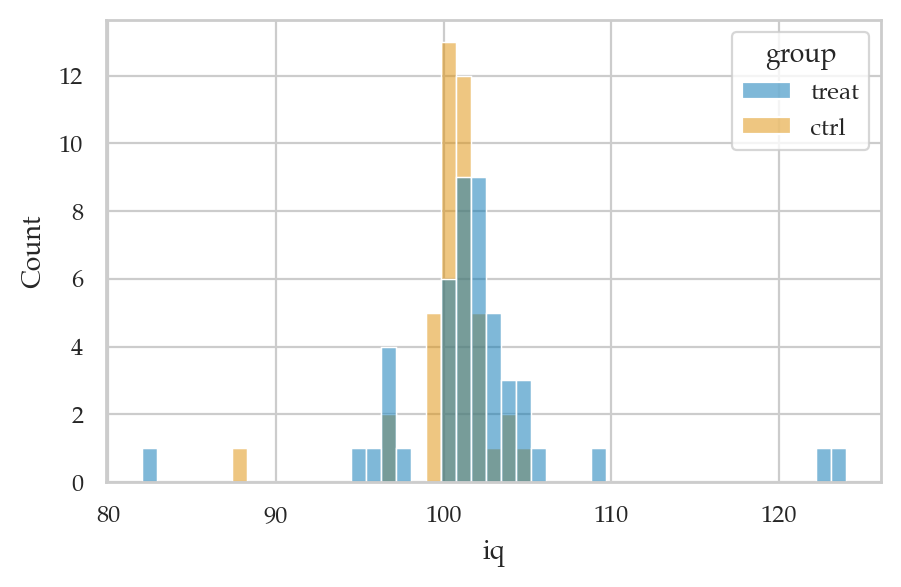

In [9]:
sns.histplot(data=iqs2, x="iq", hue="group");

### Bayesian model
TODO: add formulas

### Bambi model

In [10]:
formula2 = bmb.Formula("iq ~ 1 + group",
                       "sigma ~ 0 + group")

mod2 = bmb.Model(formula=formula2,
                 family="t",
                 link="identity",
                 data=iqs2)
mod2

       Formula: iq ~ 1 + group
                sigma ~ 0 + group
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 101.1798, sigma: 17.17)
            group ~ Normal(mu: 0.0, sigma: 23.6275)
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
    target = sigma
        Common-level effects
            sigma_group ~ Normal(mu: 0.0, sigma: 1.0)

In [11]:
# # ALT use the function
# from ministats.bayes import bayes_dmeans
# treated = iqs2[iqs2["group"]=="treat"]["iq"].values
# controls = iqs2[iqs2["group"]=="ctrl"]["iq"].values
# mod2, idata2 = bayes_dmeans(treated, controls, var_name="iq",
#                             group_name="group", groups=["treat", "ctrl"])

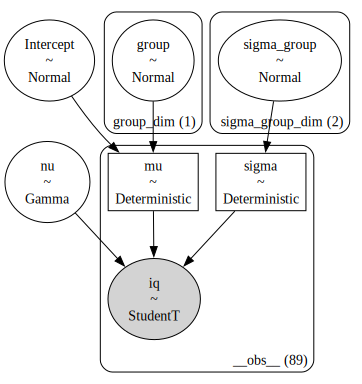

In [12]:
mod2.build()
mod2.graph()

### Model fitting and analysis

In [13]:
idata2 = mod2.fit(draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


In [14]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata2, group_name="group");
az.summary(idata2, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_treat", "sigma_ctrl", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,1.033,0.424,0.202,1.870
sigma_treat,1.941,0.407,1.194,2.756
sigma_ctrl,1.013,0.197,0.645,1.400
dstd,0.928,0.413,0.151,1.761
nu,1.809,0.469,1.023,2.744
cohend,0.686,0.303,0.121,1.308


In [15]:
# ALT. manual calculations
# post2 = idata2["posterior"]
# # Calculate sigmas from log-sigmas
# post2["sigma_treat"] = np.exp(post2["sigma_group"][:,:,1])
# post2["sigma_ctrl"] = np.exp(post2["sigma_group"][:,:,0])
# # Difference in standard deviations
# post2["dstd"] = post2["sigma_treat"] - post2["sigma_ctrl"]

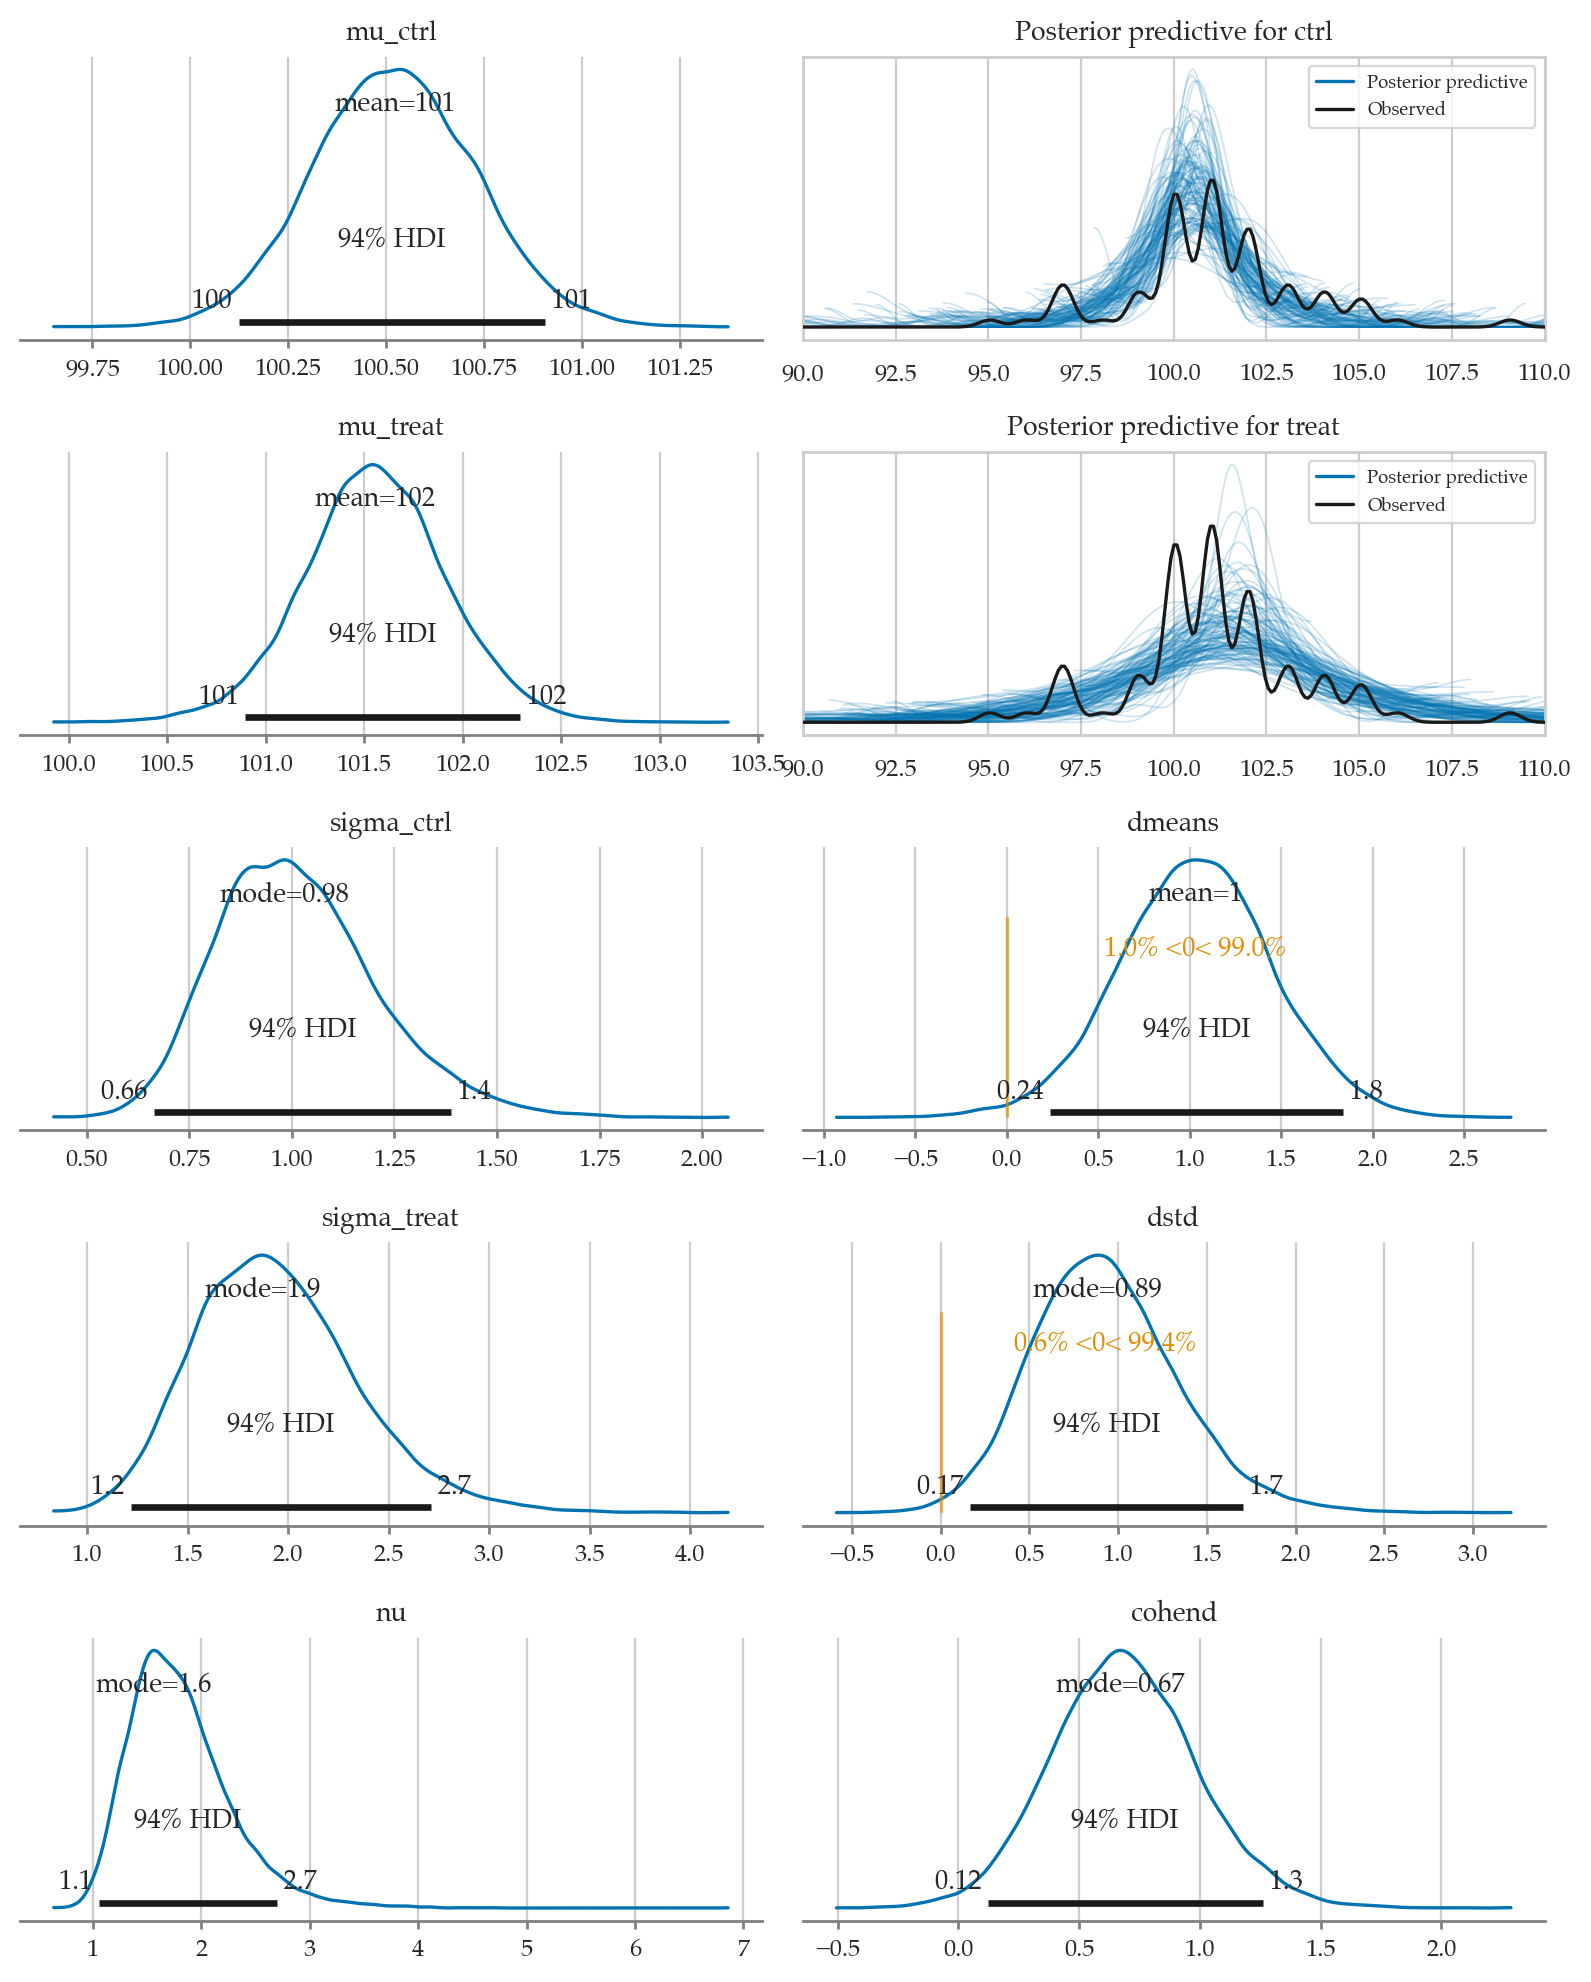

In [16]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod2, idata2, group_name="group", ppc_xlims=[90,110]);

### Compare to previous results

### Conclusions

## Example 3: lecture and debate curriculums


### Students dataset

In [17]:
students = pd.read_csv("../datasets/students.csv")
students.groupby("curriculum")["score"].describe()

,count,mean,std,min,25%,50%,75%,max
curriculum,,,,,,,,
debate,8.0,76.462500,10.519633,62.9,69.55,75.55,80.925,96.2
lecture,7.0,68.142857,7.758406,57.0,63.30,70.30,73.850,75.4


### Bayesian model
TODO: add formulas

### Bambi model

In [18]:
from ministats.bayes import bayes_dmeans

studentsD = students[students["curriculum"]=="debate"]
studentsL = students[students["curriculum"]=="lecture"]
scoresD = studentsD["score"]
scoresL = studentsL["score"]

mod3, idata3 = bayes_dmeans(scoresD, scoresL, group_name="curriculum", var_name="score", groups=["debate", "lecture"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, curriculum, sigma_curriculum]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


### Model fitting and analysis

In [19]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata3, group_name="curriculum");
az.summary(idata3, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_debate", "sigma_lecture", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,-7.015,4.689,-16.120,2.258
sigma_debate,8.642,2.681,3.501,14.027
sigma_lecture,6.604,2.207,2.515,11.177
dstd,-2.038,3.218,-8.494,4.553
nu,17.014,13.725,0.631,44.815
cohend,-0.921,0.611,-2.072,0.309


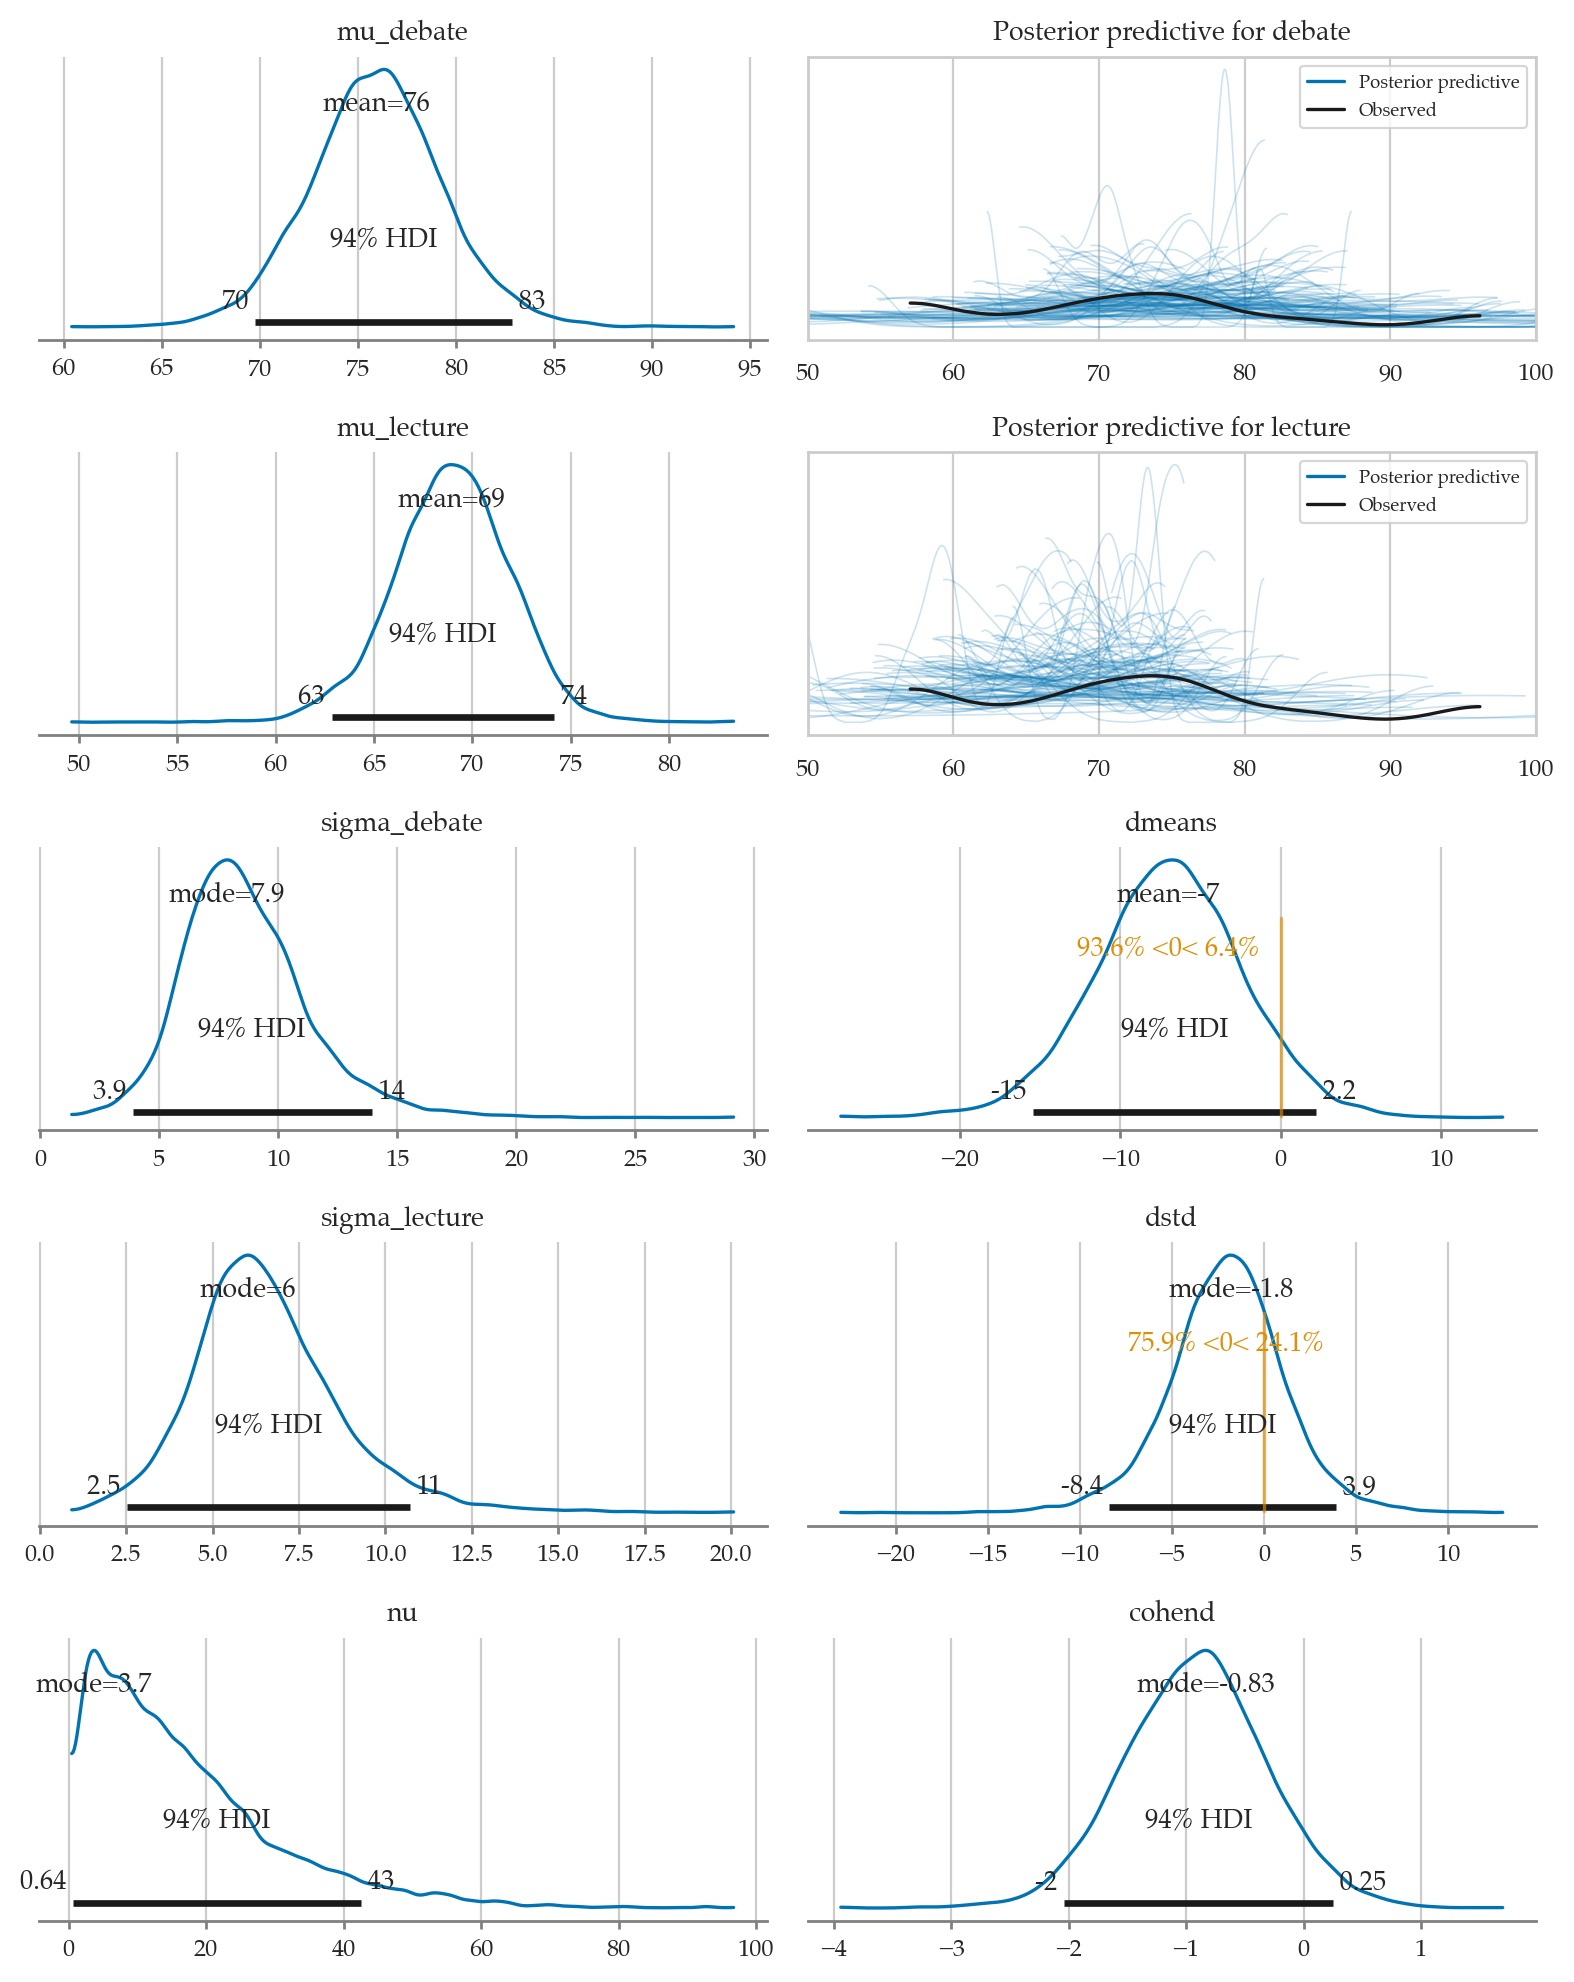

In [20]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod3, idata3, group_name="curriculum", ppc_xlims=[50,100]);

### Compare to previous results

### Conclusions

## Explanations

## Discussion

## Exercises

### Exercise 1: small samples

In [21]:
As = [5.77, 5.33, 4.59, 4.33, 3.66, 4.48]
Bs = [3.88, 3.55, 3.29, 2.59, 2.33, 3.59]
groups = ["A"]*len(As) + ["B"]*len(Bs)
df1 = pd.DataFrame({"group": groups, "vals": As + Bs})
# df1

In [22]:
from scipy.stats import t as tdist

tdist(loc=100, scale=10, df=2.1).std()

45.82575694955838

In [23]:
10 * np.sqrt(2.1 / (2.1-2))

45.82575694955838

alpha=1.0 beta=0.03333333333333333


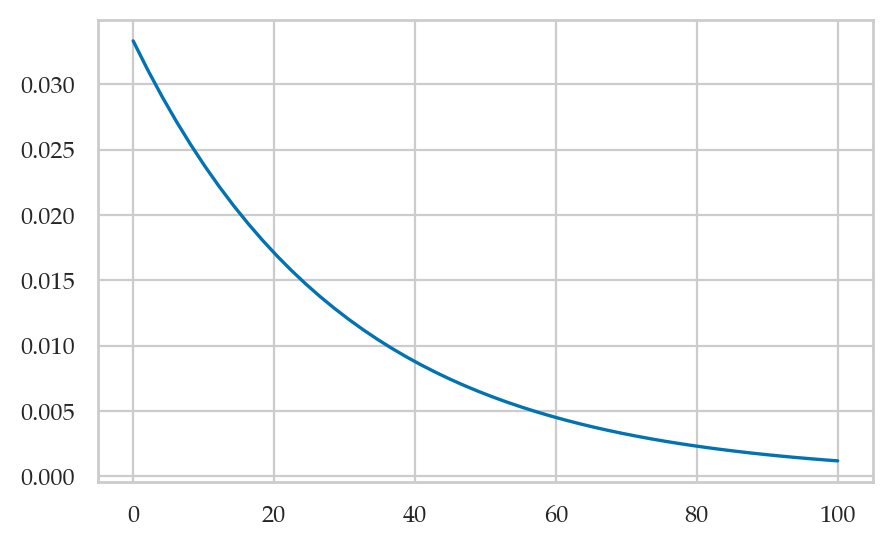

In [24]:
# New Default prior in R BEST code
from scipy.stats import gamma

nuMean = 30
nuSD = 30

alpha = nuMean**2 / nuSD**2  # shape
beta = nuMean / nuSD**2   # rate
print(f"{alpha=} {beta=}")

rv_Nu = gamma(a=alpha, scale=1/beta)
xs = np.linspace(0,100)
ax = sns.lineplot(x=xs, y=rv_Nu.pdf(xs));

<Axes: >

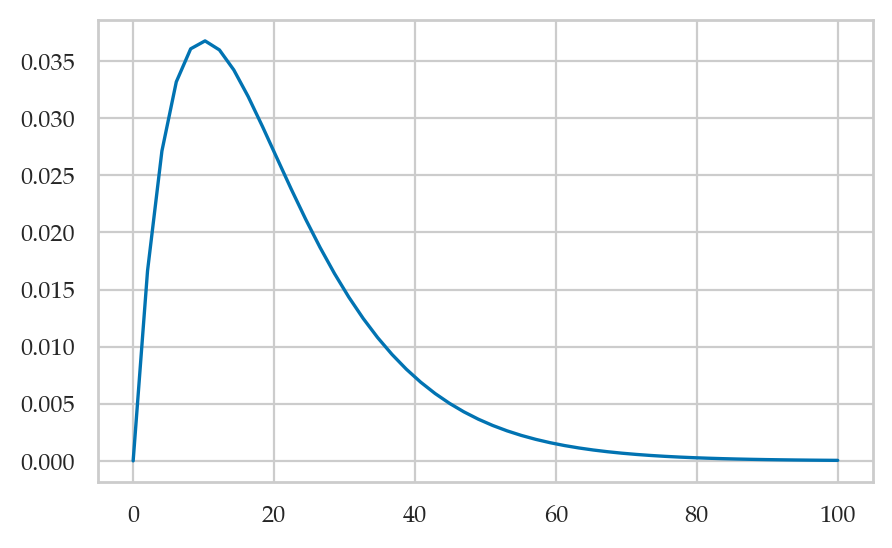

In [25]:
# Bambi default prior for `nu`
rv_Nu2 = gamma(a=2, scale=10)
xs = np.linspace(0,100)
sns.lineplot(x=xs, y=rv_Nu2.pdf(xs))

## Links

# BONUS Examples

## Example 4: small example form BEST vignette

See http://cran.nexr.com/web/packages/BEST/vignettes/BEST.pdf#page=2


In [26]:
y1s = [5.77, 5.33, 4.59, 4.33, 3.66, 4.48]
y2s = [3.88, 3.55, 3.29, 2.59, 2.33, 3.59]

from ministats.bayes import bayes_dmeans
mod4, idata4 = bayes_dmeans(y1s, y2s, groups=["y1", "y2"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [27]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata4)
az.summary(idata4, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_y1", "sigma_y2", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,-1.447,0.501,-2.422,-0.447
sigma_y1,0.854,0.335,0.376,1.512
sigma_y2,0.718,0.283,0.317,1.295
dstd,-0.136,0.440,-1.081,0.729
nu,21.583,14.481,1.240,50.088
cohend,-1.921,0.779,-3.384,-0.314


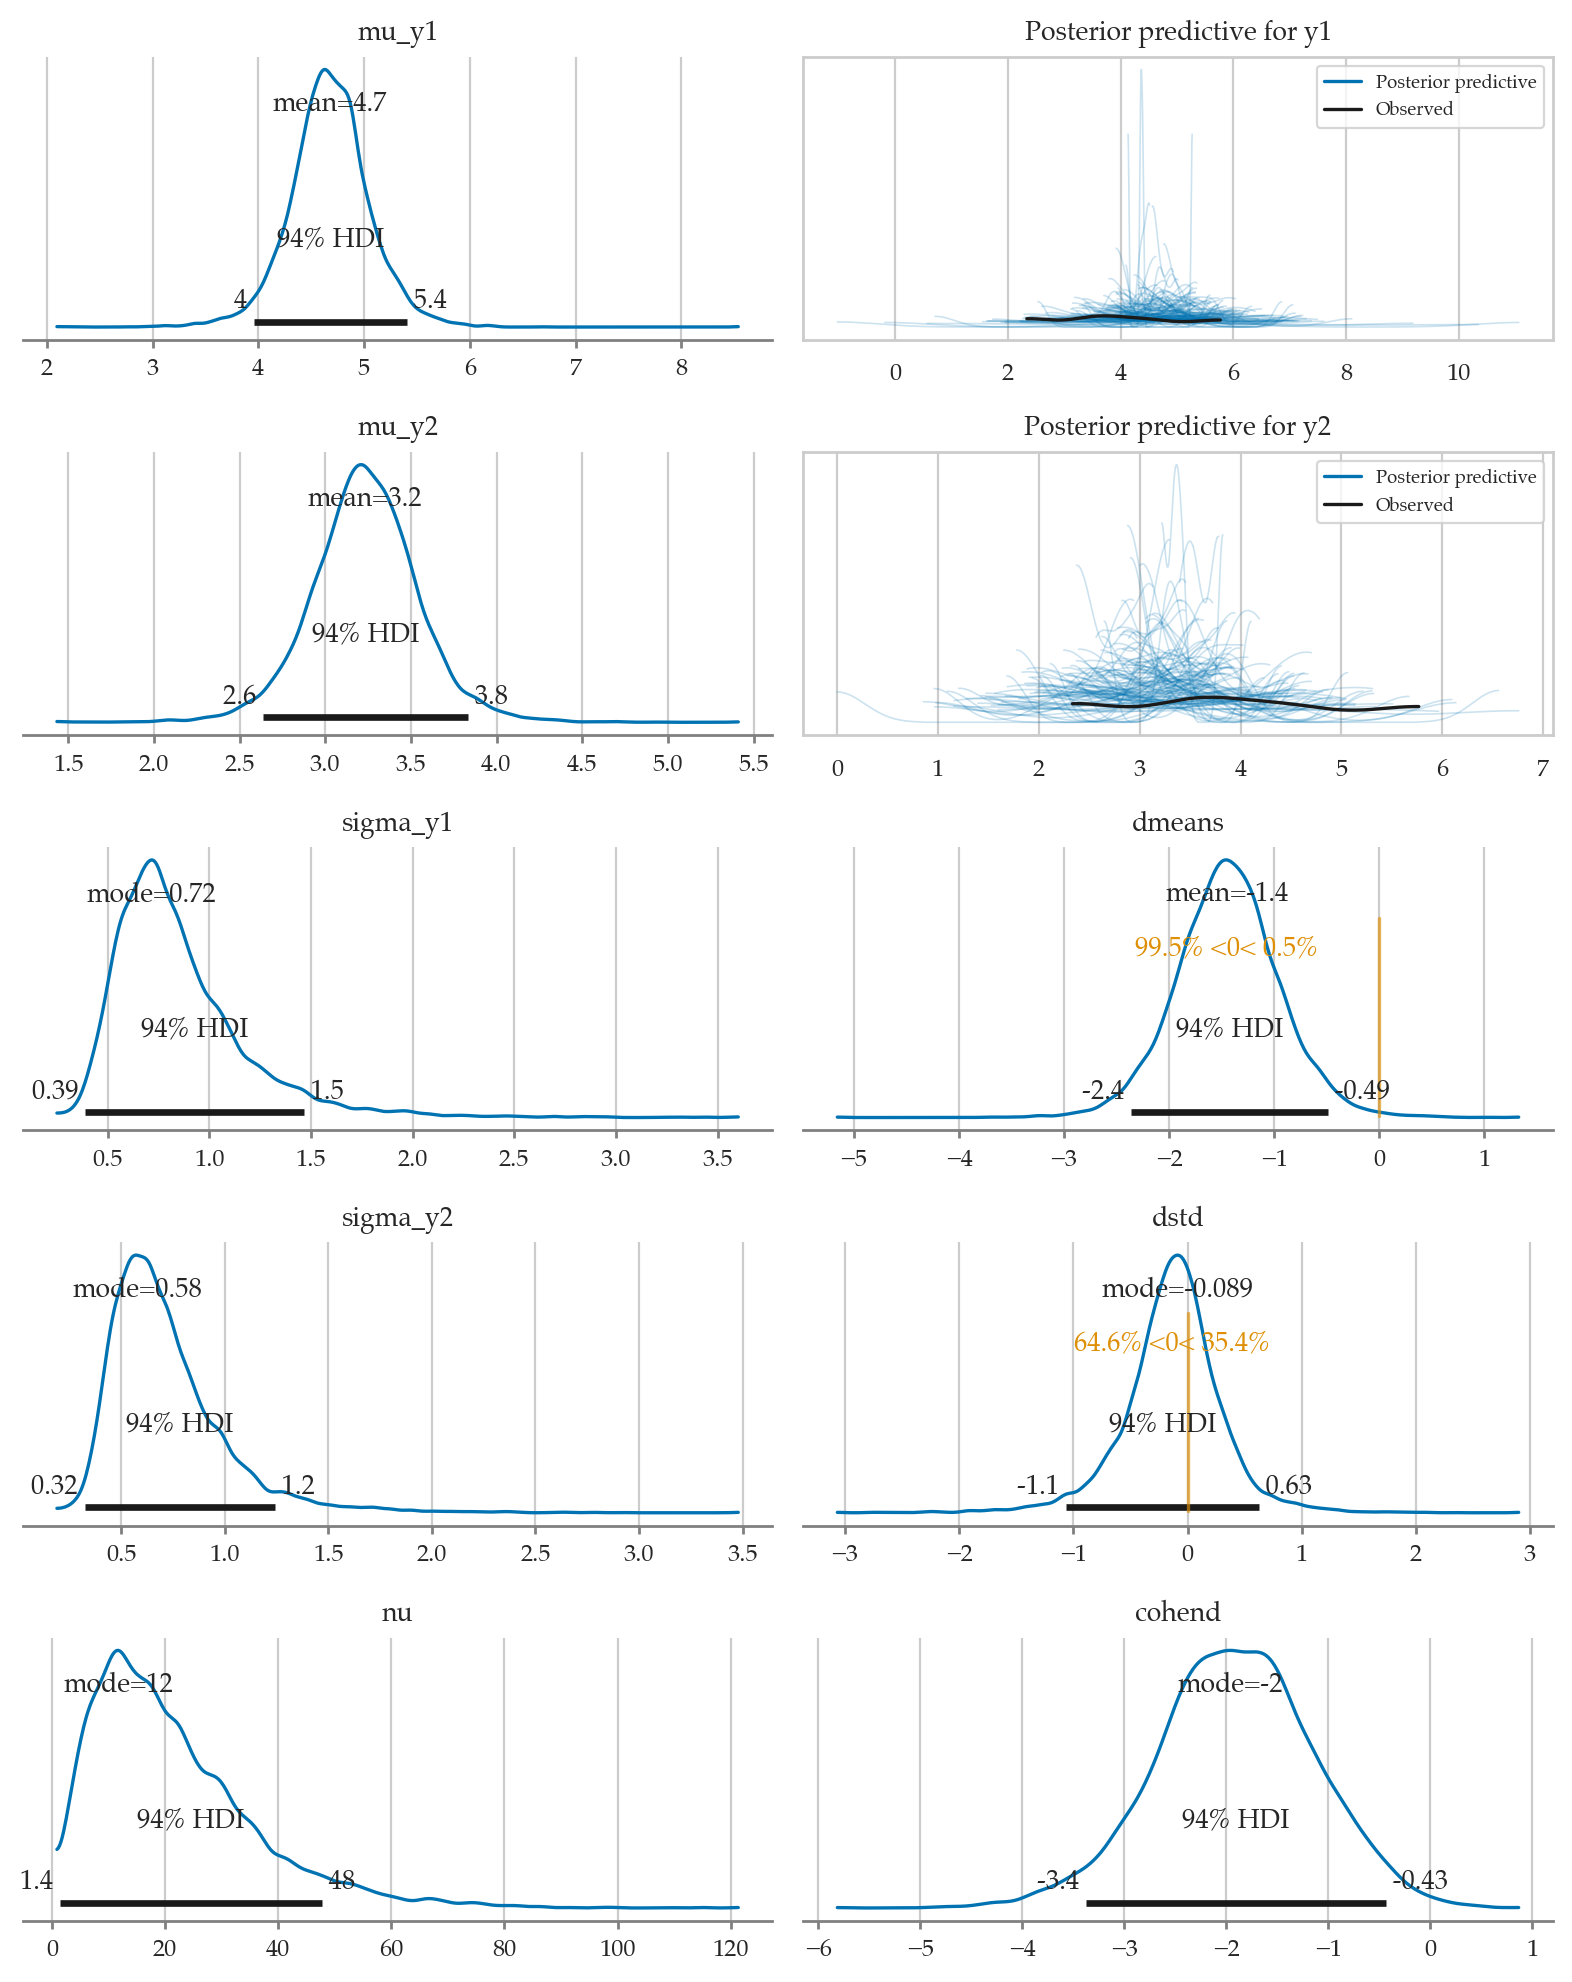

In [28]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod4, idata4, ppc_xlims=None);

## Example 5: comparing morning to evening

https://github.com/treszkai/best/blob/master/examples/paired_samples.py


In [29]:
morning = [8.99, 9.21, 9.03, 9.15, 8.68, 8.82, 8.66, 8.82, 8.59, 8.14,
           9.09, 8.80, 8.18, 9.23, 8.55, 9.03, 9.36, 9.06, 9.57, 8.38]
evening = [9.82, 9.34, 9.73, 9.93, 9.33, 9.41, 9.48, 9.14, 8.62, 8.60,
           9.60, 9.41, 8.43, 9.77, 8.96, 9.81, 9.75, 9.50, 9.90, 9.13]

In [30]:
from ministats.bayes import bayes_dmeans
mod5, idata5 = bayes_dmeans(evening, morning, groups=["evening", "morning"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [31]:
from ministats.bayes import calc_dmeans_stats
calc_dmeans_stats(idata5)
az.summary(idata5, kind="stats", hdi_prob=0.95,
           var_names=["dmeans", "sigma_evening", "sigma_morning", "dstd", "nu", "cohend"])

,mean,sd,hdi_2.5%,hdi_97.5%
dmeans,-0.530,0.139,-0.808,-0.260
sigma_evening,0.455,0.086,0.306,0.628
sigma_morning,0.387,0.073,0.260,0.539
dstd,-0.068,0.111,-0.285,0.160
nu,23.019,14.692,3.034,52.205
cohend,-1.270,0.379,-1.998,-0.511


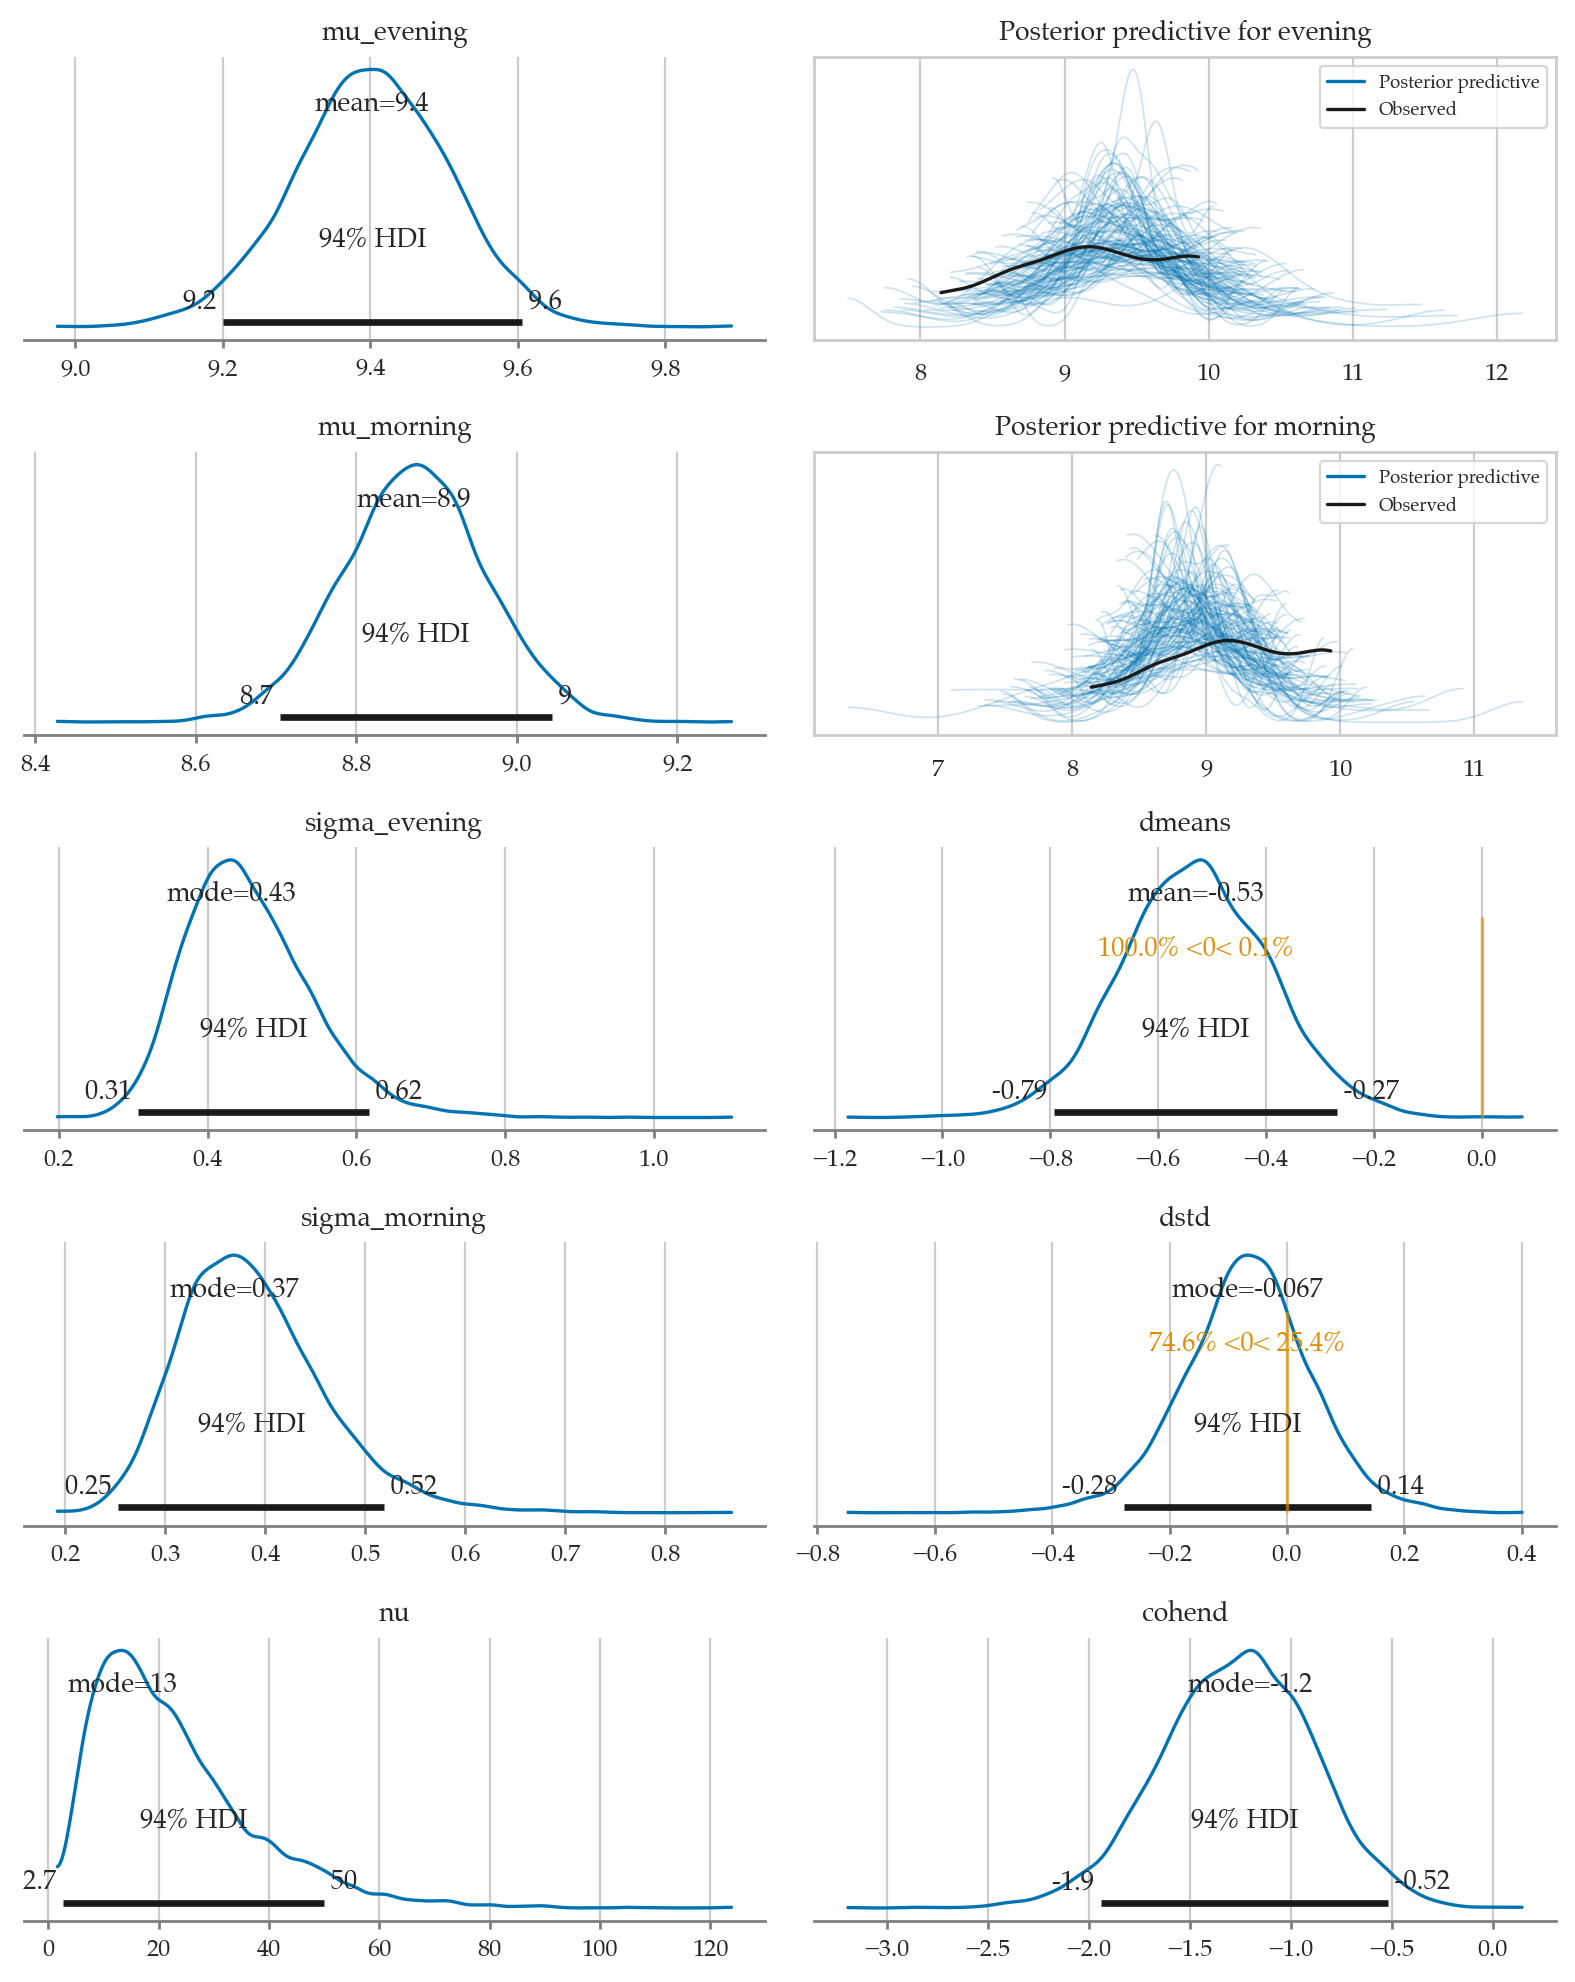

In [32]:
from ministats.bayes import plot_dmeans_stats
plot_dmeans_stats(mod5, idata5, ppc_xlims=None);